In [56]:
import numpy as np
from scipy.constants import N_A
from matplotlib import pyplot as plt
from colloids import phase
%matplotlib inline

All datafiles are calculated supposing a radius of 5.365 px (with 0.1926 µm/px, $\sigma = 2.06\,\mu m$) as given by the position of the first minimum of $g(r)$ divided by 1.3 (legacy code, don't ask). However this underestimates volume fractions, as show by time evolution of local volume fraction of 12-neighboured particles, by local volume fractions function of number of neighbours and by binodal compositions obtained by Gaussian analysis.

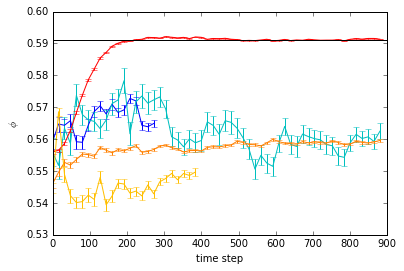

In [57]:
colors = ['b', 'c', 'r', (1,0.5,0), (1,0.75,0), (0.5,0,0), (0,0.5,0)]
av = 16
for p,c, col in zip([10]*2 + [25]*3, [0.82, 1.36, 0.38, 0.48, 0.57], colors):
    t, phi, err = np.loadtxt('data/newmediaphi_phi0.%d_cp%0.2f'%(p,c), unpack=True)
    nl = len(phi)//av
    nphi = (phi/err**2)[:av*nl].reshape((nl,av)).sum(1) / (1/err**2)[:av*nl].reshape((nl,av)).sum(1)
    nerr = (1/err**2)[:av*nl].reshape((nl,av)).sum(1)**(-0.5)
    plt.errorbar(t[:nl*av:av], nphi, nerr, color=col)
#plt.xlim(0,400)
plt.axhline(0.591, c='k')
plt.xlabel('time step')
plt.ylabel(r'$\phi$')

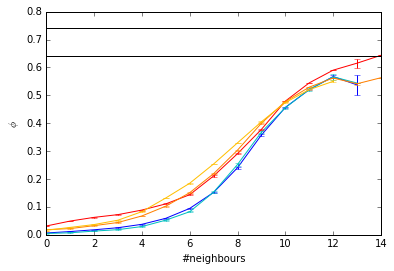

In [58]:
for p,c, col in zip([10]*2 + [25]*3, [0.82, 1.36, 0.38, 0.48, 0.57], colors):
    plt.errorbar(*np.loadtxt('data/vol_err_phi_0.%d_cp_%0.2f'%(p,c), unpack=True), color=col)
plt.axhline(0.64, color='k')
plt.axhline(0.74, color='k')
plt.xlabel('#neighbours')
plt.ylabel(r'$\phi$')

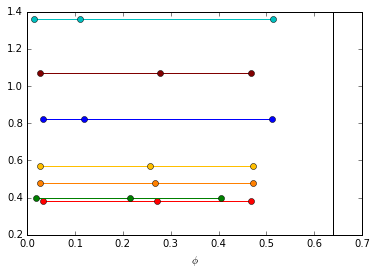

In [59]:
for (cp, phiG, phi, phiL), col in zip(np.loadtxt('data/gaussian_summary_5p365px.txt', skiprows=1), colors):
    plt.plot(np.array([phiG, phi, phiL]), [cp]*3, 'o-', color=col)
plt.axvline(0.64, c='k')
plt.xlabel(r'$\phi$')

In free volume theory, the metastable gas-liquid critical point is at a polymer concentration where the equilibrium crystal volume fraction is 0.723. This should be the final local volume fraction of the 12-neighboured particles in our crystallising sample. Therefore, we will scale all volume fractions by

In [60]:
#mulphi = 0.723/np.loadtxt('data/vol_err_phi_0.%d_cp_%0.2f'%(25,0.38))[12,1]
phiX = 0.723
mulphi = phiX/np.loadtxt('data/newmediaphi_phi0.%d_cp%0.2f'%(25,0.38),usecols=[1])[300:].mean()
sigma = 2*5.365*0.1926e-6 * mulphi**(1/3) #in metre
print('sigma=%0.2f µm'%(sigma*1e6))

sigma=2.21 µm


Draw and save scaled local volume fractions of 12-neighboured particles.

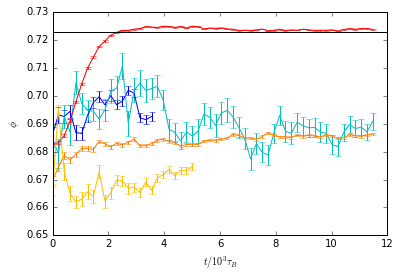

In [61]:
av = 16
for p,c, col in zip([10]*2 + [25]*3, [0.82, 1.36, 0.38, 0.48, 0.57], colors):
    t, phi, err = np.loadtxt('data/mediaphi_phi0.%d_cp%0.2f'%(p,c), unpack=True)
    phi *= mulphi
    err *= mulphi
    nl = len(phi)//av
    nphi = (phi/err**2)[:av*nl].reshape((nl,av)).sum(1) / (1/err**2)[:av*nl].reshape((nl,av)).sum(1)
    nerr = (1/err**2)[:av*nl].reshape((nl,av)).sum(1)**(-0.5)
    plt.errorbar(t[:nl*av:av]*30/2.3e3, nphi, nerr, color=col)
    np.savetxt(
        'data/mediaphi_phi0.%d_cp%0.2f.scaled'%(p,c), 
        np.column_stack((t[:nl*av:av]*30/2.3e3, 100*nphi, 100*nerr)), 
        header='t_1000tB\tphi\terr', comments='')
#plt.xlim(0,400)
plt.axhline(phiX, c='k')
plt.xlabel(r'$t/10^3\tau_B$')
plt.ylabel(r'$\phi$')

Draw and save scaled local volume fractions function of the number of neighbours.

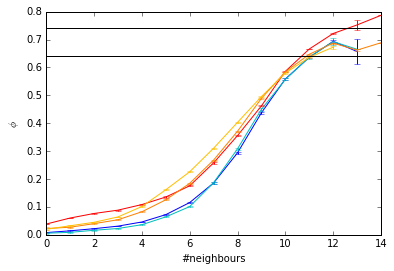

In [62]:
for p,c, col in zip([10]*2 + [25]*3, [0.82, 1.36, 0.38, 0.48, 0.57], colors):
    n, phi, err = np.loadtxt('data/vol_err_phi_0.%d_cp_%0.2f'%(p,c), unpack=True)
    phi *= mulphi
    err *= mulphi
    plt.errorbar(n, phi, err, color=col)
    np.savetxt(
        'data/vol_err_phi_0.%d_cp_%0.2f.scaled'%(p,c), 
        np.column_stack((n, 100*phi, 100*err)), 
        header='n\tphi\terr\n', comments='')
plt.axhline(0.64, color='k')
plt.axhline(0.74, color='k')
plt.xlabel('#neighbours')
plt.ylabel(r'$\phi$')

Non crystallising samples have local volume fraction above random close packing 0.64. Still the crystallizing sample is above.

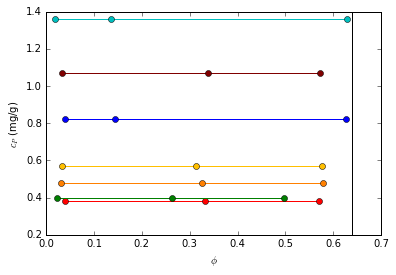

In [79]:
for (cp, phiG, phi, phiL), col in zip(np.loadtxt('data/gaussian_summary_5p365px.txt', skiprows=1), colors):
    plt.plot(mulphi*np.array([phiG, phi, phiL]), [cp]*3, 'o-', color=col)
plt.axvline(0.64, c='k')
plt.xlabel(r'$\phi$')
plt.ylabel('$c_P$ (mg/g)')

The liquid binodal is close and below radom close packing for all samples.

Draw the experimental compositions and try to adjust the polymer size to get the binodal at the gel boundary.

In [66]:
def getGLspxp(sigma, R, Mw=3.6e6, d=1.24, fluid=phase.CarnahanStarling()):
    """Fast gas spinodal computation"""
    qR = 2*R/sigma
    cpov = 1000 * (3 * Mw)/(4 * np.pi * R**3 * N_A * d*1e6)
    q = phase.qR2q(qR)
    GL = fluid.spinodalGL(q)
    return [(phase.f2vf(f), phase.piv2y(GL[:,0], qR) * phase.alpha(f, q) * cpov) for f in GL.T[1:]]

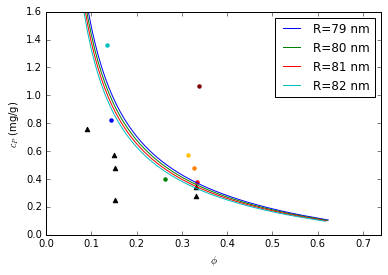

In [81]:
phixpF = np.array([0.141, 0.141, 0.139, 0.084, 0.307, 0.309])/(5.6/5.365)**3*mulphi
cpxpF = np.array([0.25,0.48,0.57, 0.76, 0.28, 0.34])

plt.scatter(phixpF, cpxpF, c='k', marker='^')
for (cp, phi), col in zip(np.loadtxt('data/gaussian_summary_5p365px.txt', skiprows=1, usecols=[0,2]), colors):
    plt.scatter(phi*mulphi, cp, c=col, marker='o', lw=0)

for R in range(79,83,1):
    for x,y in getGLspxp(sigma, R*1e-9)[:1]:
        plt.plot(x,y,label='R=%d nm'%R)
    
plt.xlim(0,0.74)
plt.ylim(0,1.6)
plt.xlabel(r'$\phi$')
plt.ylabel('$c_P$ (mg/g)')
plt.legend(loc='upper right')

The best polymer radius of gyration is 80 nm. Compute the theoretical phase diagram accordingly.

In [68]:
R = 80e-9
Mw=3.6e6
d=1.24
qR = 2*R/sigma
cpov = 1000 * (3 * Mw)/(4 * np.pi * R**3 * N_A * d*1e6)
q = phase.qR2q(qR)
print('qR = %0.3f, q = %0.3f, Cov = %0.3f mg/g'%(qR, q, cpov))

#gas-liquid binodal and spinodal
GL = phase.Liu().all_GL(q, maxpiv=2400)
    
#fluid-crystal coexistence
FS = phase.all_coexistence(q, phase.Liu(), phase.Hall(), maxpiv=2400)

qR = 0.072, q = 0.076, Cov = 2.248 mg/g


In [20]:
def xp2th(cp, phi, qR=0.1, cpov=1.):
    """Converts experimental polymer concentration in osmotic pressure"""
    return phase.y2piv(cp / cpov / phase.alpha(phase.vf2f(phi), phase.qR2q(qR)), qR)

Cross-check that the  coexisting crystal is indeed at 0.723

In [71]:
cp, phiG, phi, phiL = np.loadtxt('data/gaussian_summary_5p365px.txt', skiprows=1)[2]
piv = xp2th(cp, phi*mulphi, qR, cpov)
phase.f2vf(FS[np.where(FS[:,0]>piv)[0][0],1:])

array([  3.32662459e-05,   7.22997284e-01])

Draw the phase diagram in theoretical representation. In [Fleer & Tuinier Adv Colloid Interface Sci. 2008](https://dx.doi.org/10.1016/j.cis.2008.07.001) the polymer reservoir osmotic pressure $\Pi$ is scaled by the volume of a colloid $v= \frac{\pi}{6} \sigma^3$ to yield an energy.

When the size ratio is small, there is no triple overlap of depleted volumes, so the effect of depletion is well described by an Asakura-Oosawa potential. The depth of the potential is $E_0 = \Pi v_\mathrm{ov}$ where $v_\mathrm{ov}$ is the overlap volume between the depleted zones of two particles at contact.

$$v_\mathrm{ov}=\frac{\pi}{4}\sigma^3 q^2 \left(1+\frac{2}{3}q\right)$$

$$E_0 = \frac{v_\mathrm{ov}}{v} \Pi v = \frac{3}{2}q^2 \left(1+\frac{2}{3}q\right) \Pi v$$

In [74]:
plt.subplots?

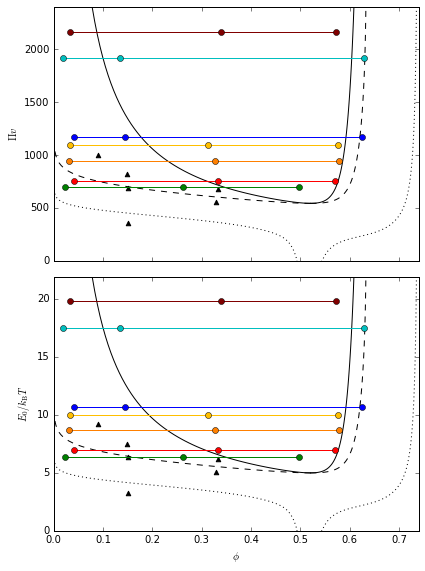

In [78]:
#conversion factor between the two representations
Piv2E = 3/2 * q**2 * (1+2*q/3)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=False, num='Theoretical phase diagram', figsize=(6,8))

ax[0].set_xlim(0,0.74)
ax[0].set_ylim(0,2400)
ax[1].set_ylim(0,2400*Piv2E)
ax[1].set_xlabel(r'$\phi$')
ax[0].set_ylabel(r'$\Pi v$')
ax[1].set_ylabel(r'$E_0/k_\mathrm{B}T$')

#draw and save theoretical lines
for f,l, ph in zip(GL.T[1:], ['--']*2+['-']*2, ['bg', 'bl', 'sg', 'sl']):
    ax[0].plot(phase.f2vf(f), GL[:,0], 'k'+l)
    ax[1].plot(phase.f2vf(f), GL[:,0]*Piv2E, 'k'+l)
    np.savetxt(
        'res_gasliquid_%s.phd'%ph,
        np.column_stack((phase.f2vf(f), GL[:,0], GL[:,0]*Piv2E)),
        header='phi\tPiv\tE0',
        )
for f, ph in zip(FS.T[1:], 'fx'):
    ax[0].plot(phase.f2vf(f), FS[:,0], 'k:')
    ax[1].plot(phase.f2vf(f), FS[:,0]*Piv2E, 'k:')
    np.savetxt(
        'res_fluidcrystal_%s.phd'%ph,
        np.column_stack((phase.f2vf(f), FS[:,0], FS[:,0]*Piv2E)),
        header='phi\tPiv\tE0',
        )
    
#experimental fluid points
ax[0].scatter(phixpF, xp2th(cpxpF, phixpF, qR, cpov), c='k', marker='^')
ax[1].scatter(phixpF, xp2th(cpxpF, phixpF, qR, cpov)*Piv2E, c='k', marker='^')
np.savetxt(
    'res_fluid_samples.phd', 
    np.column_stack((phixpF, xp2th(cpxpF, phixpF, qR, cpov), xp2th(cpxpF, phixpF, qR, cpov)*Piv2E)), 
    header='phi\tPiv\tE0', fmt='%0.3f'
)

#phase separating points
for (cp, phiG, phi, phiL), col,s in zip(np.loadtxt('data/gaussian_summary_5p365px.txt', skiprows=1), colors, range(7)):
    piv = xp2th(cp, phi*mulphi, qR, cpov)
    ax[0].plot(np.array([phiG, phi, phiL])*mulphi, [piv]*3, '-o', color=col)
    ax[1].plot(np.array([phiG, phi, phiL])*mulphi, [piv*Piv2E]*3, '-o', color=col)
    np.savetxt(
        'res_sample%d.phd'%s, 
        np.column_stack((np.array([phiG, phi, phiL])*mulphi, [piv]*3, [piv*Piv2E]*3)), 
        header='phi\tPiv\tE0', fmt='%0.3f'
    )

plt.tight_layout()


Draw the phase diagram in experimental variables

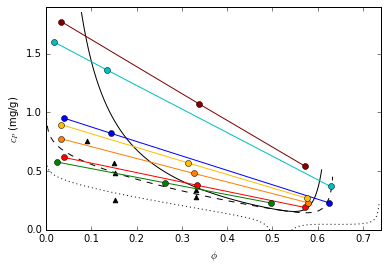

In [82]:
#draw and save theoretical lines
for f,l,ph in zip(GL.T[1:], ['--']*2+['-']*2, ['bg', 'bl', 'sg', 'sl']):
    phis = phase.f2vf(f)
    cps = phase.piv2y(GL[:,0], qR) * phase.alpha(f, q) * cpov
    plt.plot(phis, cps, 'k'+l)
    np.savetxt(
        'gasliquid_%s.phd'%ph,
        np.column_stack((phis, cps)),
        header='phi\tcp',
        )
    
for f, ph in zip(FS.T[1:], 'fx'):
    phis = phase.f2vf(f)
    cps = phase.piv2y(FS[:,0], qR) * phase.alpha(f, q) * cpov
    plt.plot(phis, cps, 'k:')
    np.savetxt(
        'fluidcrystal_%s.phd'%ph,
        np.column_stack((phis, cps)),
        header='phi\tcp',
        )

#experimental fluid points
plt.scatter(phixpF, cpxpF, c='k', marker='^')
np.savetxt('fluid_samples.phd', np.column_stack((phixpF, cpxpF)), header='phi\tcp', fmt='%0.3f')

#phase separating points
for (cp, phiG, phi, phiL), col, s in zip(
    np.loadtxt('data/gaussian_summary_5p365px.txt', skiprows=1), 
    colors, range(7)
):
    phis = np.array([phiG, phi, phiL])*mulphi
    piv = xp2th(cp, phis[1], qR, cpov)
    cps = phase.piv2y(piv, qR) * phase.alpha(phase.vf2f(phis), q) * cpov
    plt.plot(phis, cps, '-o', color=col)
    np.savetxt('sample%d.phd'%s, np.column_stack((phis, cps)), header='phi\tcp', fmt='%0.3f')
plt.xlim(0,0.74)
plt.ylim(0,1.9)
plt.xlabel(r'$\phi$')
plt.ylabel('$c_P$ (mg/g)')

Time evolution of the volume fraction of 12-neighboured particles.

In [23]:
np.loadtxt('data/gaussian_summary_5p365px.txt', skiprows=1, usecols=[2])*mulphi

array([ 0.14427196,  0.13449081,  0.3325591 ,  0.32644588,  0.3129968 ,
        0.33867232,  0.26286841])

### Comparision with Carnahan-Starling results

In [24]:
GL2 = phase.CarnahanStarling().all_GL(q, maxpiv=2400)

/data/src/colloids/python/colloids/phase.py:145: RuntimeWarning: overflow encountered in exp
  return self.pv(np.exp(F), piv, q)
/data/src/colloids/python/colloids/phase.py:229: RuntimeWarning: invalid value encountered in double_scalars
  return f/(1+f) + 4*f**2 + 2* f**3
/data/src/colloids/python/colloids/phase.py:72: RuntimeWarning: invalid value encountered in double_scalars
  beta1 = lambda f,q: -beta(f,q)*Q1(f,q)
/data/src/colloids/python/colloids/phase.py:136: RuntimeWarning: overflow encountered in exp
  f = np.exp(F)
/data/src/colloids/python/colloids/phase.py:26: RuntimeWarning: invalid value encountered in double_scalars
  t = x/(x + 2.0)
/data/src/colloids/python/colloids/phase.py:241: RuntimeWarning: invalid value encountered in double_scalars
  return - logOnePlusX(f) + 8*f + 7*f**2 + 2*f**3
/home/mathieu/anaconda3/lib/python3.5/site-packages/scipy/optimize/minpack.py:236: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from th

(0, 2400)

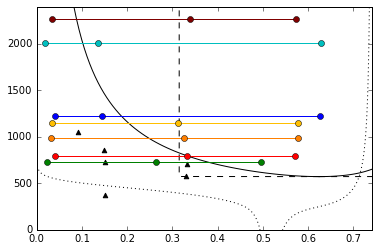

In [25]:
#draw and save theoretical lines
for f,l, ph in zip(GL2.T[1:], ['--']*2+['-']*2, ['bg', 'bl', 'sg', 'sl']):
    plt.plot(phase.f2vf(f), GL[:,0], 'k'+l)
    np.savetxt(
        'res_gasliquidCS_%s.phd'%ph,
        np.column_stack((phase.f2vf(f), GL2[:,0])),
        header='phi\tPiv',
        )
for f, ph in zip(FS.T[1:], 'fx'):
    plt.plot(phase.f2vf(f), FS[:,0], 'k:')
    
#experimental fluid points
plt.scatter(phixpF, xp2th(cpxpF, phixpF, qR, cpov), c='k', marker='^')

#phase separating points
for (cp, phiG, phi, phiL), col,s in zip(np.loadtxt('data/gaussian_summary_5p365px.txt', skiprows=1), colors, range(7)):
    piv = xp2th(cp, phi*mulphi, qR, cpov)
    plt.plot(np.array([phiG, phi, phiL])*mulphi, [piv]*3, '-o', color=col)

plt.xlim(0,0.74)
plt.ylim(0,2400)

(0, 1.9)

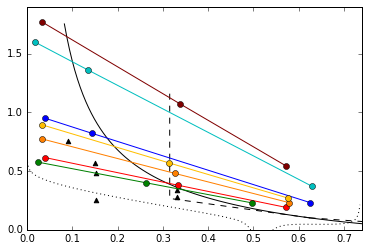

In [26]:
#draw and save theoretical lines
for f,l,ph in zip(GL2.T[1:], ['--']*2+['-']*2, ['bg', 'bl', 'sg', 'sl']):
    phis = phase.f2vf(f)
    cps = phase.piv2y(GL2[:,0], qR) * phase.alpha(f, q) * cpov
    plt.plot(phis, cps, 'k'+l)
    np.savetxt(
        'gasliquidCS_%s.phd'%ph,
        np.column_stack((phis, cps)),
        header='phi\tcp',
        )
    
for f, ph in zip(FS.T[1:], 'fx'):
    phis = phase.f2vf(f)
    cps = phase.piv2y(FS[:,0], qR) * phase.alpha(f, q) * cpov
    plt.plot(phis, cps, 'k:')

#experimental fluid points
plt.scatter(phixpF, cpxpF, c='k', marker='^')
np.savetxt('fluid_samples.phd', np.column_stack((phixpF, cpxpF)), header='phi\tcp', fmt='%0.3f')

#phase separating points
for (cp, phiG, phi, phiL), col, s in zip(
    np.loadtxt('data/gaussian_summary_5p365px.txt', skiprows=1), 
    colors, range(7)
):
    phis = np.array([phiG, phi, phiL])*mulphi
    piv = xp2th(cp, phis[1], qR, cpov)
    cps = phase.piv2y(piv, qR) * phase.alpha(phase.vf2f(phis), q) * cpov
    plt.plot(phis, cps, '-o', color=col)

plt.xlim(0,0.74)
plt.ylim(0,1.9)

## Asakura-Oosawa escape time

Kramers 1940 give the exact expression for the escape time out of a potential well:
$$\tau_\mathrm{esc} 
= \frac{1}{D_s} \int_\sigma^{(1+q)\sigma} \exp\frac{-U(r)}{k_\mathrm{B}T}dr \int_\sigma^{(1+q)\sigma} \exp\frac{U(r)}{k_\mathrm{B}T}dr
= \frac{\delta^2}{D_s} \int_0^1 \exp\frac{-U(x)}{k_\mathrm{B}T}dx \int_0^1 \exp\frac{U(x)}{k_\mathrm{B}T}dx$$

The diffusion coefficient $D_s$ corresponds to the diffusion in the well, that we can approximate to the diffusion coefficient in a suspension of hard spheres where the mean distance between particles is $\delta$. That is to say $$D_s \approx D\left(\phi = \frac{0.64}{(1+q)^3}\right)$$

In [91]:
0.64/(1+q)**3

0.51353448967550575

According to [Segrè _et al._ Phys Rev E. 1995](https://dx.doi.org/10.1103/PhysRevE.52.5070)
$$\frac{D(\phi=0)}{D(\phi\approx 0.5)}\approx 5$$

$$\tau_\mathrm{esc} \approx 5q^2 \tau_B \int_0^1 \exp\frac{-U(x)}{k_\mathrm{B}T}dx \int_0^1 \exp\frac{U(x)}{k_\mathrm{B}T}dx$$

In [83]:
from scipy import integrate

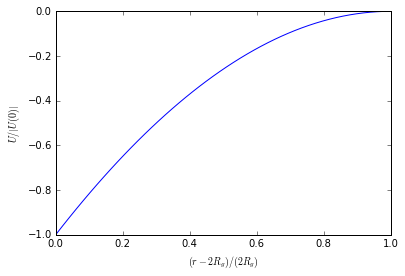

In [88]:
uAO = lambda x,q: -(x-1)**2 * (3 + 2*q + 3*q*x)/(3 + 2*q)
plt.plot(np.linspace(0,1), uAO(np.linspace(0,1), q))
plt.xlabel('$(r-2 R_g)/(2 R_g)$')
plt.ylabel('$U/|U(0)|$')

In [95]:
def escape_time(E0, q):
    """Escape time in units Browian time. Effective diffusion coefficient is taken for q~0.1"""
    a = integrate.quad(lambda x:np.exp(-E0*uAO(x,q)), 0, 1)[0]
    b = integrate.quad(lambda x:np.exp(E0*uAO(x,q)), 0, 1)[0]
    return 5 * q**2 * a * b

Expected bond breaking rates in $4\tau_B$

In [97]:
for E0 in range(1,11):
    print(4/escape_time(E0, q))

126.219891977
97.2982049162
64.4747677603
37.7696616033
20.1398510956
10.0231636718
4.7446248143
2.16488638826
0.960896685693
0.417502261793


In [102]:
for s in range(7):
    phi, E0 = np.loadtxt('res_sample%d.phd'%s, usecols=[0,2])[1]
    print('phi=%g\tE0=%g\tPbreak=%g'%(phi, E0, 4/escape_time(E0, q)))

phi=0.144	E0=10.706	Pbreak=0.229383
phi=0.134	E0=17.497	Pbreak=0.000551758
phi=0.333	E0=6.941	Pbreak=4.96427
phi=0.326	E0=8.656	Pbreak=1.27405
phi=0.313	E0=9.998	Pbreak=0.418206
phi=0.339	E0=19.801	Pbreak=6.66074e-05
phi=0.263	E0=6.368	Pbreak=7.64986
